In [1]:
"""
Created on Aug 8 14:24:37 2020

@author: Nicolas Matentzoglu
"""

import os, sys
import yaml
import urllib.request
from shutil import copyfile
import pandas as pd
from subprocess import check_call
from lib import uPhenoConfig, get_defined_phenotypes

### Configuration
yaml.warnings({'YAMLLoadWarning': False})
#upheno_config_file = sys.argv[1]
#upheno_config_file = os.path.join("/Users/matentzn/ws/upheno-dev/src/curation/upheno-config.yaml")
#ws = "/Users/matentzn/tmp_data/var/lib/jenkins/workspace/upheno2-pipeline@2/src"
upheno_eq_analysis = "/Users/matentzn/ws/upheno-dev/src/ontology/reports/upheno-eq-analysis.csv"


upheno_config = uPhenoConfig(upheno_config_file)
os.environ['ROBOT_JAVA_ARGS'] = upheno_config.get_robot_java_args()

TIMEOUT=str(upheno_config.get_external_timeout())
robot_opts=upheno_config.get_robot_opts()

pattern_dir = os.path.join(ws,"curation/patterns-for-matching/")
stats_dir = os.path.join(ws,"curation/upheno-stats/")
matches_dir = os.path.join(ws,"curation/pattern-matches/")



def get_all_phenotypes(upheno_config,stats_dir):
    phenotypes = []
    for oid in upheno_config.get_phenotype_ontologies():
        phenotype_class_metadata = os.path.join(stats_dir,oid+"_phenotype_data.csv")
        if os.path.exists(phenotype_class_metadata):
            try:
                df = pd.read_csv(phenotype_class_metadata)
                df['o']=oid
                phenotypes.append(df)
            except:
                print("{} could not be loaded..".format(phenotype_class_metadata))
        else:
            print("{} does not exist!".format(phenotype_class_metadata))
    return pd.concat(phenotypes)


defined = get_defined_phenotypes(upheno_config,pattern_dir,matches_dir)
df_pheno = get_all_phenotypes(upheno_config,stats_dir)
df_pheno['upheno']=df_pheno['s'].isin(defined)
df_pheno['eq']=df_pheno['ldef'].notna()
df_pheno.drop_duplicates(inplace=True)

print("Summary: ")
print(df_pheno.head())
print(df_pheno.describe())
print("")
print("How many uPheno conformant classes?")
print(df_pheno[['s','upheno']].groupby('upheno').count())
print("")
print("How many classes with EQs?")
print(df_pheno[['s','eq']].groupby('eq').count())
print("")
print("How many uPheno conformant classes that do not have EQs (bug!!)?")
print(df_pheno[df_pheno['upheno'] & (~df_pheno['eq'])])
print(df_pheno[df_pheno['upheno']][['s','eq']].groupby('eq').count())
df_pheno.to_csv(os.path.join(stats_dir,"pheno_eq_analysis.csv"))

In [3]:
#del df_pheno['ldef']
#del df_pheno['lab']
df_pheno = pd.read_csv(upheno_eq_analysis)
df_pheno.head()


,Unnamed: 0,s,lab,ldef,o,upheno,eq
0,0,http://purl.obolibrary.org/obo/MP_0000001,mammalian phenotype,NaN,mp,False,False
1,1,http://purl.obolibrary.org/obo/MP_0002006,neoplasm,NaN,mp,False,False
2,2,http://purl.obolibrary.org/obo/MP_0002166,abnormal tumor susceptibility,_:b0,mp,False,True
3,3,http://purl.obolibrary.org/obo/MP_0010307,abnormal tumor latency,NaN,mp,False,False
4,4,http://purl.obolibrary.org/obo/MP_0010308,decreased tumor latency,NaN,mp,False,False


In [4]:
df_pheno_o=df_pheno[['s','o']].groupby(['o']).count()
df_pheno_o=df_pheno_o.add_suffix('_Count').reset_index()
df_pheno_o.columns=['o','total_phenotypes']
df_pheno_o

,o,total_phenotypes
0,apo,223
1,ddpheno,1020
2,dpo,244
3,fypo,8135
4,hp,18387
5,mgpo,71
6,mp,14279
7,phipo,1106
8,planp,645
9,wbphenotype,2650


In [5]:
df_pheno_o_eq=df_pheno[['s','o','eq']].groupby(['o','eq']).count()
df_pheno_o_eq=df_pheno_o_eq.add_suffix('_Count').reset_index()
df_pheno_o_eq=df_pheno_o_eq[df_pheno_o_eq['eq']]
del df_pheno_o_eq['eq']
df_pheno_o_eq.columns=['o','total_eq']
df_pheno_o_eq

,o,total_eq
2,ddpheno,1005
4,dpo,216
6,fypo,6074
8,hp,6241
10,mgpo,63
12,mp,10277
14,phipo,532
15,planp,645
17,wbphenotype,964
18,xpo,20340


In [6]:
df_pheno_o_eq_upheno=df_pheno[['s','o','upheno']].groupby(['o','upheno']).count()
df_pheno_o_eq_upheno=df_pheno_o_eq_upheno.add_suffix('_Count').reset_index()
df_pheno_o_eq_upheno=df_pheno_o_eq_upheno[df_pheno_o_eq_upheno['upheno']]
del df_pheno_o_eq_upheno['upheno']
df_pheno_o_eq_upheno.columns=['o','upheno']
df_pheno_o_eq_upheno

,o,upheno
2,ddpheno,843
4,dpo,138
6,fypo,26
8,hp,4679
10,mgpo,14
12,mp,7567
14,phipo,508
16,planp,582
18,wbphenotype,719
20,xpo,20260


In [7]:
result = pd.merge(df_pheno_o, df_pheno_o_eq, on='o')
result = pd.merge(result, df_pheno_o_eq_upheno, on='o')
result['remain_no_def']=result['total_phenotypes']-result['total_eq']
result['eq_not_upheno']=result['total_eq']-result['upheno']

result

,o,total_phenotypes,total_eq,upheno,remain_no_def,eq_not_upheno
0,ddpheno,1020,1005,843,15,162
1,dpo,244,216,138,28,78
2,fypo,8135,6074,26,2061,6048
3,hp,18387,6241,4679,12146,1562
4,mgpo,71,63,14,8,49
5,mp,14279,10277,7567,4002,2710
6,phipo,1106,532,508,574,24
7,planp,645,645,582,0,63
8,wbphenotype,2650,964,719,1686,245
9,xpo,20340,20340,20260,0,80


In [8]:
result=result[['o','remain_no_def','eq_not_upheno','upheno','total_phenotypes']]
result['pc_remain_no_def']=(result['remain_no_def']/result['total_phenotypes'])
result['pc_eq_not_upheno']=(result['eq_not_upheno']/result['total_phenotypes'])
result['pc_upheno']=(result['upheno']/result['total_phenotypes'])
r=result[['o','pc_remain_no_def','pc_eq_not_upheno','pc_upheno']]

In [9]:
result

,o,remain_no_def,eq_not_upheno,upheno,total_phenotypes,pc_remain_no_def,pc_eq_not_upheno,pc_upheno
0,ddpheno,15,162,843,1020,0.014706,0.158824,0.826471
1,dpo,28,78,138,244,0.114754,0.319672,0.565574
2,fypo,2061,6048,26,8135,0.253350,0.743454,0.003196
3,hp,12146,1562,4679,18387,0.660575,0.084951,0.254473
4,mgpo,8,49,14,71,0.112676,0.690141,0.197183
5,mp,4002,2710,7567,14279,0.280272,0.189789,0.529939
6,phipo,574,24,508,1106,0.518987,0.021700,0.459313
7,planp,0,63,582,645,0.000000,0.097674,0.902326
8,wbphenotype,1686,245,719,2650,0.636226,0.092453,0.271321
9,xpo,0,80,20260,20340,0.000000,0.003933,0.996067


In [10]:
r
r.to_csv("/Users/matentzn/tmp_data/upheno.csv")

In [29]:
r.columns = ['ontologies','No EQ definition','EQ, not uPheno','uPheno conformant EQ']

<Axes: xlabel='ontologies'>

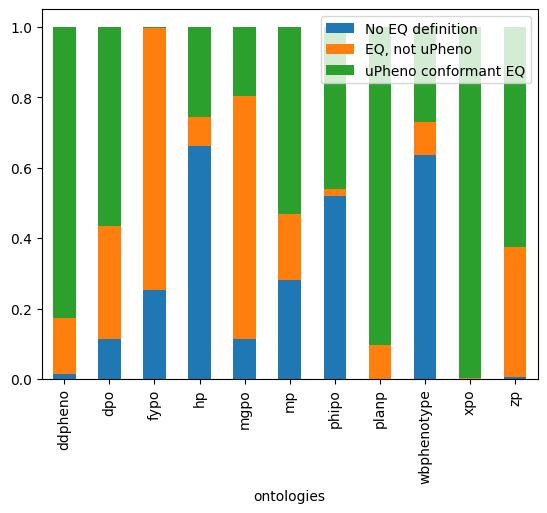

In [30]:
r.set_index('ontologies').plot(kind='bar', stacked=True)